# [IAPR][iapr]: Final project - Chocolate Recognition


**Moodle group ID:** *36*  
**Kaggle challenge:** *Classic* 
**Kaggle team name (exact):** "*Group36*"  

**Author 1 (SCIPER):** *Antoine Violet (310842)*  
**Author 2 (SCIPER):** *Luan Dinarica (296963)*  
**Author 3 (SCIPER):** *Rayan Fuleihan (310832)*  
**Author 4 (SCIPER):** *Fanny Ghez (310560)*  

**Due date:** 21.05.2025 (11:59 pm)


## Key Submission Guidelines:
- **Before submitting your notebook, <span style="color:red;">rerun</span> it from scratch!** Go to: `Kernel` > `Restart & Run All`
- **Only groups of three will be accepted**, except in exceptional circumstances.


[iapr]: https://github.com/LTS5/iapr2025

---

This project aims to develop a model that would be able to recognize and classify different types of chocolates. The pipeline has two main steps: segmentation and classification.

# Segmentation

This part focuses on outlining each chocolate in the image pixel by pixel using a U-Net model. The model was trained on images resized to 256 × 256 pixels and outputs a binary mask indicating which areas correspond to chocolates.

## Dataset and Annotations

The dataset used in this project consists of top-down images of multiple chocolates on different backgrounds. Each image is annotated through Roboflow in a JSON file where the boundaries of chocolates are clearly defined. These annotations are used to generate training masks where each chocolate is represented by a white circle of fixed radius (290 pixels). All generated masks are stored in a separate folder (`train_mask`) with filenames matching the original images.

## Data Augmentation

Because the dataset is relatively small, data augmentation is necessary to increase variability and help the model generalize. A custom `SegmentationDataset` class was created to load each RGB image and its corresponding binary mask, ensure correct formatting, and apply augmentations, including:

- Horizontal/Vertical flipping (`0.1`)
- Random rotations (`0.3`)
- Color jitter (`0.1`)
- Gaussian blur (`0.1`)
- Elastic transformations (`0.2`)
- Cutout (`0.5`)
- Cutout 2 (`0.5`)

- The elastic transformation randomly distorts the image by applying smooth deformations similar to those seen in real-life pictures.
- The cutout transformation removes small patches (10×30 pixels, 10 times per image). It forces the model to focus on surrounding areas.
- The cutout2 version removes fewer but larger patches (3 patches up to 120×120 pixels). It simulates stronger occlusions and encourages the model to learn more robust spatial features.

These augmentations were carefully tuned to increase visual variety without introducing unrealistic distortions. They were the main driver behind improving the segmentation quality. By randomly altering images in this way, the model was trained on many diverse scenarios, effectively expanding the dataset and preventing overfitting.


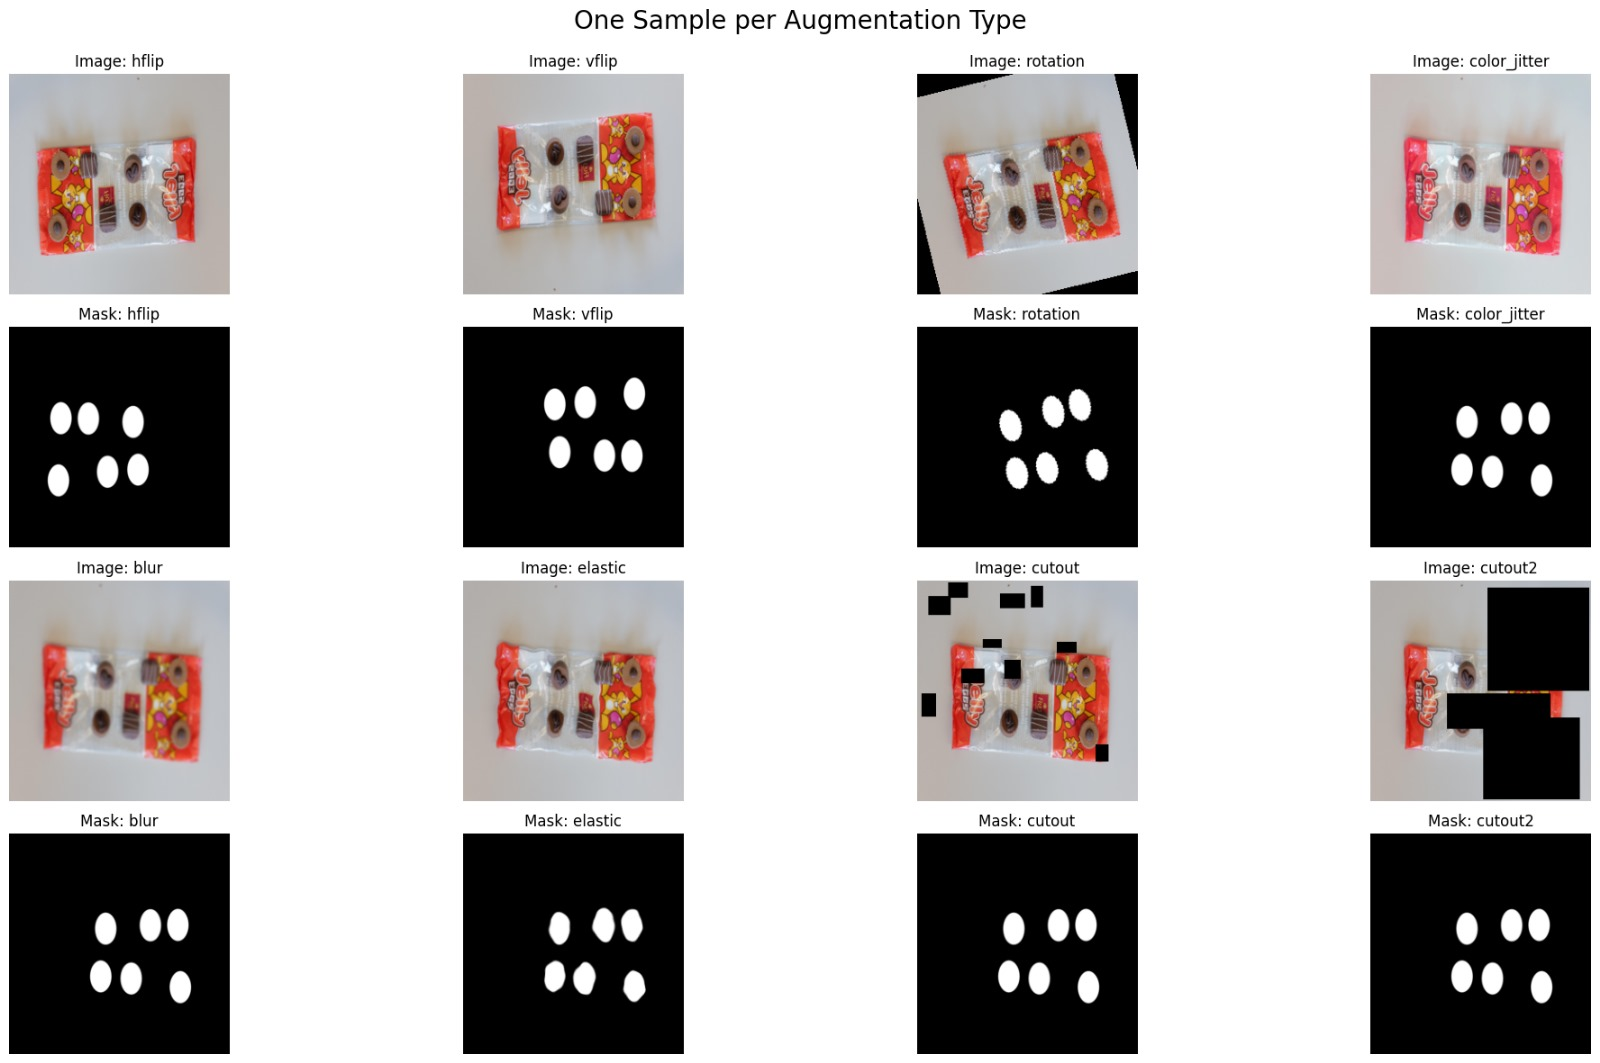

In [17]:
display(Image(filename='image_report/Data_Augmentation.jpeg'))

## U-Net Model Architecture

The model used for segmentation is based on the U-Net architecture, where the goal is to assign a label to each pixel. U-Net has a U-shaped structure with two main parts: a contracting path (encoder) and an expanding path (decoder).

- Encoder: Gradually reduces the spatial size of the image while increasing the number of channels. This is achieved through repeated blocks of 3×3 convolutional layers, batch normalization, ReLU activations, and max-pooling operations. The number of filters progressively increases from 64 to 256 as the image is downsampled, causing loss of spatial detail but gaining broader contextual understanding.

- Decoder: Performs the opposite action, reconstructing the original image size step by step using transposed convolutions (stride 2). The decoder reduces the number of filters back from 512 to 64, allowing precise pixel-level predictions. Skip connections between encoder and decoder stages help recover spatial details lost during downsampling.

Finally, the network outputs a probability map via a 1×1 convolutional layer with a sigmoid activation. Each pixel value indicates the probability of belonging to a chocolate (between 0 and 1). After applying a threshold, a binary segmentation mask is obtained, indicating chocolate regions (`1`) and background (`0`).  
The total number of trainable parameters in the U-Net is `7,702,977`. 

## Training Loop

The training process for the U-Net model runs through several iterations (25 epochs). During each epoch, images and masks are processed in mini-batches using a DataLoader. The model predicts masks and compares them to manually annotated masks using the Binary Cross-Entropy Loss (BCELoss). The Adam optimizer then adjusts the model weights to reduce prediction errors, using a learning rate of `1e-3`. Over multiple epochs, this loop gradually improves the model’s segmentation accuracy.

## Watershed Post-processing

During segmentation, we noticed some chocolates were so close together that the model detected them as a single blob, making counting or classifying difficult.

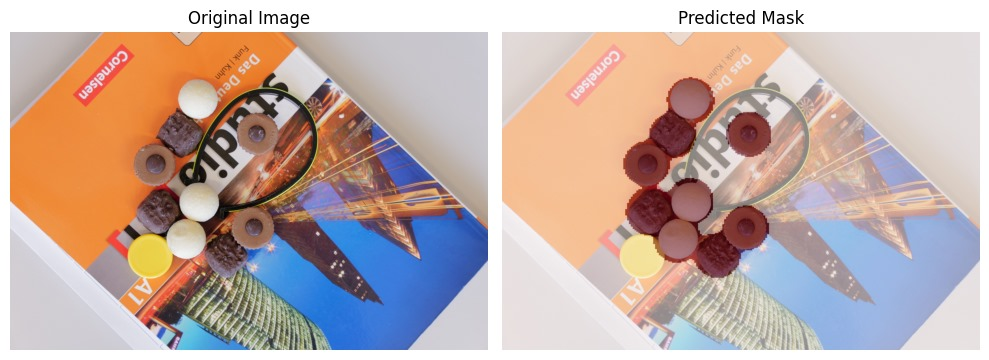

In [18]:
from IPython.display import Image, display
display(Image(filename='image_report/Watershed_B.jpeg'))

 To solve this, we implemented the watershed algorithm.

Watershed first uses a distance map, highlighting pixel distances from blob edges, with the highest points marking likely chocolate centers. The algorithm then "cuts" the merged blobs by growing regions outward from these centers until they meet. This method splits large blobs into smaller, separate blobs, accurately representing individual chocolates, even when they touch or overlap. This significantly improves the model's ability to correctly detect and classify each chocolate.




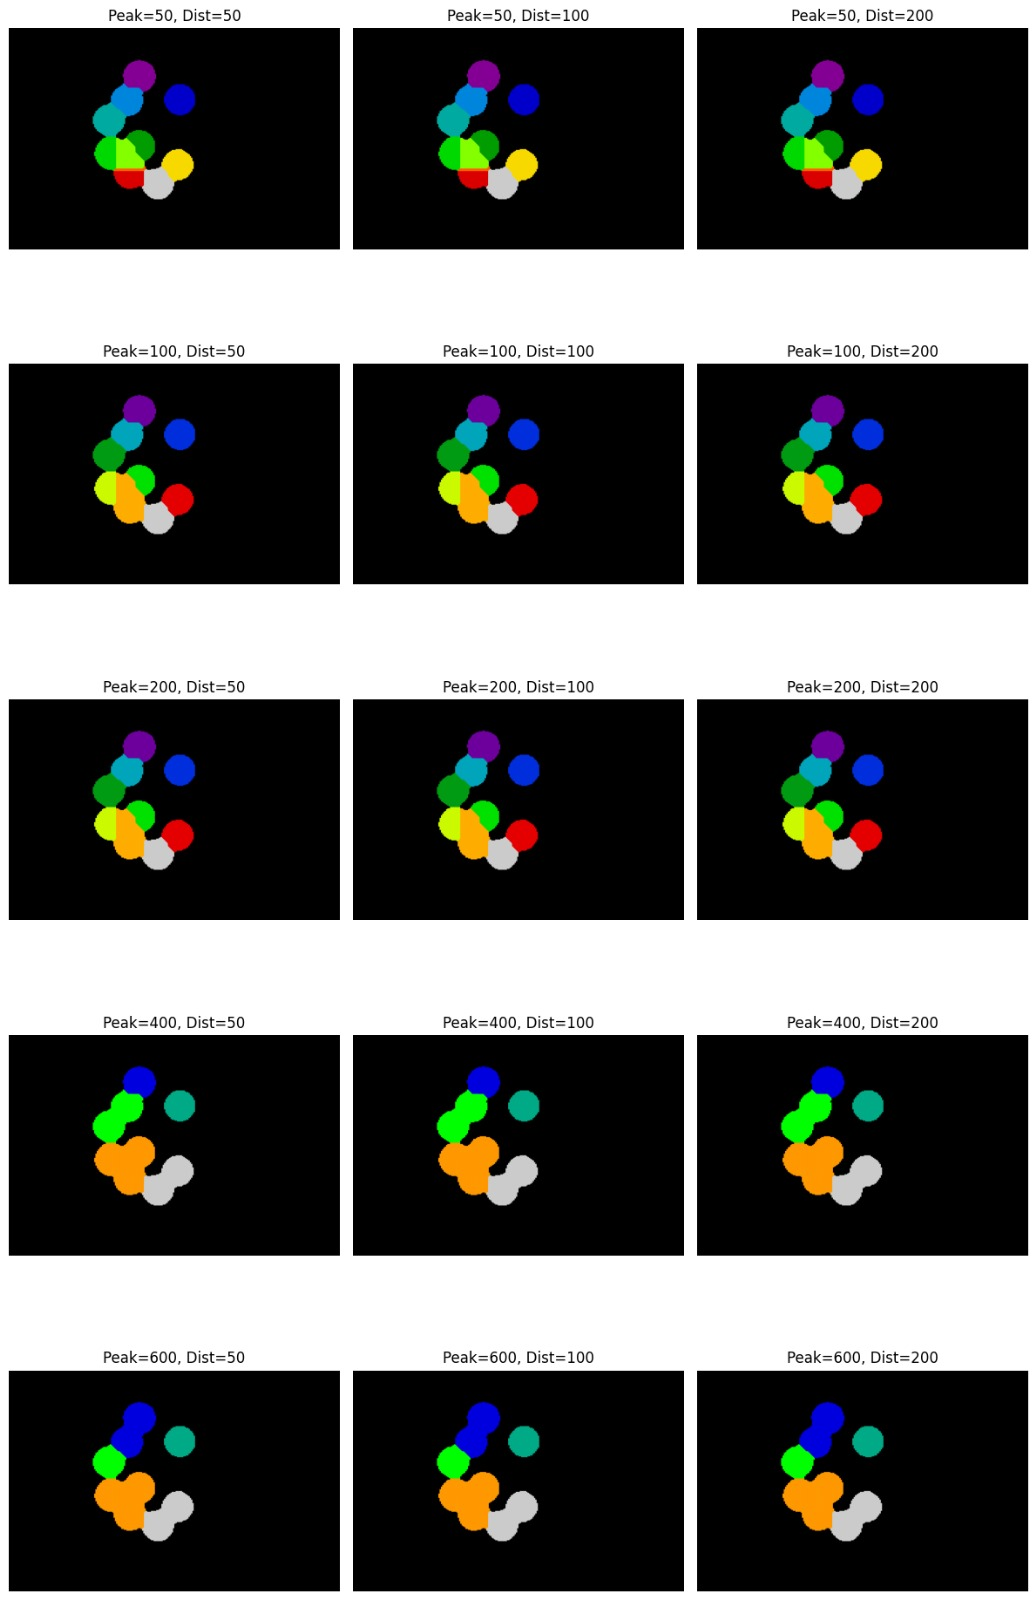

In [19]:
display(Image(filename='image_report/Watershed_A.jpeg'))


We experimented extensively with different parameter values for the watershed algorithm to effectively separate chocolates that were closely positioned. The images above illustrate several of these tests, demonstrating how changing the parameters `min_peak_distance` (Peak) and `min_distance_value` (Dist) significantly impacts the algorithm's performance in splitting overlapping chocolates.

After carefully evaluating multiple combinations, we determined that Peak = 200 and Dist = 200 provided some of the best results. This parameter choice reliably separated closely touching chocolates without creating unwanted splits.

# CNN Classification 

## Dataset and Annotations

The model has been trained with the same annoted dataset from Roboflow as in the Segmentation part. 
These annotations allow to have masks with high precision.

## Data Augmentation 

Since the dataset for classification was relatively small, data augmentation was necessary to increase variability and help the CNN generalize. A custom `CocoChocolateDataset` class was created to load each image patch, ensure correct formatting, and apply augmentations, including:

- *Random Horizontal Flip* randomly mirrors the image horizontally.
- *Random Resized Crop* simulates zoom variations by randomly cropping and resizing. (scale `0.6–1.0`, ratio `0.75–1.33`)
- *Random Rotation* applies slight rotations.(`±15 degrees`)
- *Color Jitter* randomly adjusts brightness, contrast, and saturation.(`brightness=0.3, contrast=0.3, saturation=0.3`)
- *Random Affine* introduces translations, scale changes, and shear to mimic realistic viewing angles.(`translate=0.1`, `scale=0.8–1.2`, `shear=10°`)
- *Random Erasing* randomly removes small rectangular patches, preventing over-reliance on specific image features.(`0.5`)

These augmentations were carefully tuned and were the main method for improving classification accuracy and preventing overfitting. They significantly increased the dataset's diversity without introducing unrealistic distortions, allowing the CNN to generalize better to unseen images.


## CNN Classifier Architecture (ChocolateNet)

We built a custom Convolutional Neural Network (CNN) architecture, named *ChocolateNet*, which is designed to identify different chocolate types from images. The pipeline is composed of two primary components: a feature extraction stage and a classification stage.

### Feature Extraction 

The feature extraction component reduces spatial dimensions and increase channel depth. The different channels capture different features of the image, in which the early layers learn general features, while the final layers have more abstract functions. 

This stage is built from sequential convolutional blocks, each consisting of:

- ⁠*Convolutional Layers (3×3 kernels)*: Learnable element of the CNN, extract spatial patterns and visual characteristics from the chocolate images
- ⁠*Batch Normalization*: Stabilizes and accelerates training 
- ⁠*ReLU Activations*: Introduce non-linearity
- ⁠*Max Pooling*: Decreases the spatial resolution progressively(elarge the receptive field)


### Classification Stage

After the feature extraction, the spatial dimensions are reduced through an *Adaptive Average Pooling* operation, which allow to only specify the output size.

This stage includes:

- ⁠*Flattening Layer*: Converts multidimensional feature maps into a one-dimensional vector.
- ⁠*Fully Connected Layers*: Learn complex nonlinear relationships and map extracted features to class predictions. An intermediate fully connected layer of 512 neurons is used.
- ⁠*Dropout Layer*: Randomly deactivating 50% of the neurons during training, to reduce overfitting 
- ⁠*Output Layer*: A final fully connected layer outputs class logits 

The final output consists of unnormalized logits, which, after applying a softmax function, yield probabilities indicating the likelihood of each chocolate category.

### Training Loop

The ChocolateNet model is trained over 15 epochs, where in each we :

- ⁠Load augmented image batches via a Custom DataLoader. Inside we have implemented a Weighted Random Sampler to handle class imbalance effectively
- ⁠Apply Mixup augmentation: Randomly mixes pairs of training samples to enhance generalization and smooth decision boundaries.
- ⁠Forward propagation: Produces predictions for chocolate type classification.
- ⁠Loss computation: Uses a Cross-Entropy Loss with label smoothing (0.1), discouraging overly confident predictions and stabilizing training.
- ⁠Backpropagation: Updates model weights using the Adam optimizer coupled with a OneCycle Learning Rate Scheduler(starting learning rate: 1e-3), dynamically adjusting the learning rate during training.

 The total number of trainable parameters is `4'186'002`. 


### Post-training Evaluation

To assess the model’s performance, various metrics and visualizations are employed:

- ⁠*Accuracy*: Measures overall classification correctness.
- ⁠*Confusion Matrix*: Highlights specific strengths and weaknesses of the classifier across chocolate categories.
- ⁠*Classification Report*: Provides precision, recall, and F1-score for each class, enabling detailed performance analysis.
- ⁠*Class Activation Maps (CAM)*: Visualize regions in the images influencing predictions, validating the feature extraction mechanism.
- ⁠*High-dimensional Embeddings (e.g., t-SNE)*: Demonstrates the separability of learned features across chocolate types.

# Visualizing What the Models Learn

To better understand how our models process and learn from the images, we visualized internal layers of both the U-Net and the CNN.

## U-Net Feature Maps and Kernels

We first visualized the kernels of the first convolutional layer in the U-Net. These kernels are like filters that detect basic visual patterns such as edges, textures, or color changes. By looking at them, we can get a sense of what types of low-level features the model is learning right from the input image.

Next, we used a forward hook to capture feature maps from an intermediate layer, specifically `'up3'` in the decoder. Feature maps show what the model "sees" at each layer. The figure titled *"Feature maps at 'up3'"* displays several channels that highlight different parts of the image, such as chocolate edges or texture details. This helps us verify that the model is focusing on relevant visual areas during the reconstruction.

## CNN Feature Maps

We applied a similar approach to the classification CNN. By attaching a forward hook to layers in the CNN (such as after each convolutional block), we could extract and visualize the feature maps during inference.

This helps us understand how the CNN gradually builds a high-level understanding of the chocolates : going from basic shapes in early layers to more abstract and class-specific patterns in deeper layers. Visualizing CNN activations allows us to ensure the model is learning meaningful representations and focusing on the correct image regions when classifying chocolate types.

Overall, this type of visualization is a useful tool to inspect and interpret deep learning models and confirm they are behaving as expected.



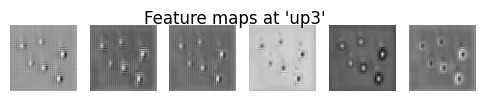

In [22]:
display(Image(filename='image_report/Image.jpeg'))

# Inference #
Once the models are trained, the inference process begins. A test image is first passed through the U-Net to generate a segmentation mask. The watershed algorithm is then applied to split overlapping chocolates. Each detected region is cropped from the original image. Finally, these regions are passed through the CNN to classify the type of each chocolate.


# Troubleshooting & Limitations #

The classifier performs well overall, achieving an accuracy of over 93% on the public test set, with most samples correctly classified along the diagonal.

However, some confusion remains. For instance, "Noir authentique" experiences a few misclassifications, but the overall performance on the validation set is very good.


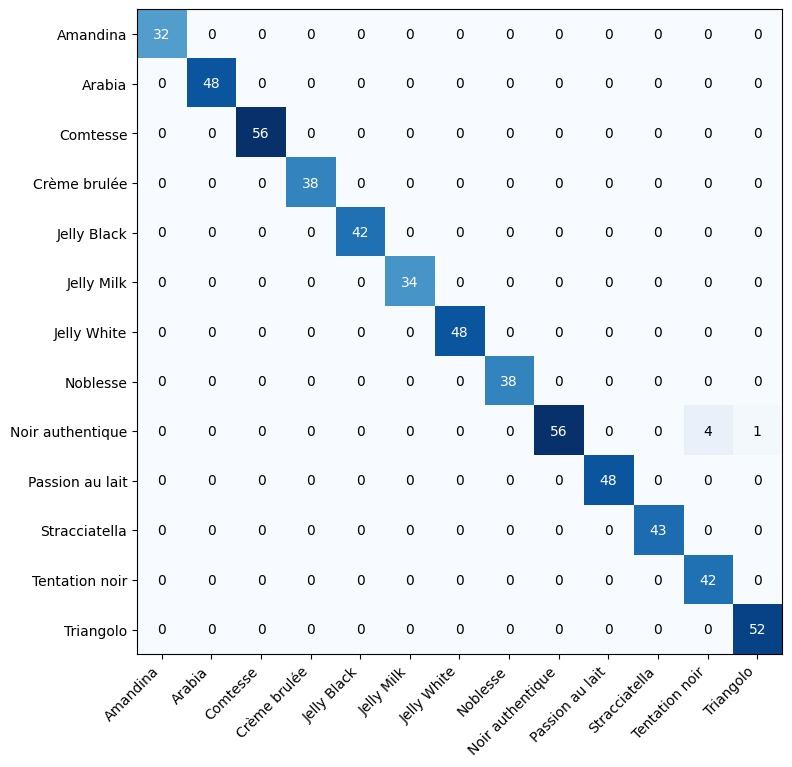

In [21]:
display(Image(filename='image_report/Classification_Matrix.jpeg'))

However, when we run the classifier on masks generated from segmentation, we observe that the classifier makes slightly more errors. As shown in the graph, the most frequent misclassifications are "Jelly Milk" identified as "Passion au lait", "Jelly White" as "Comtesse", and "Noir Authentique" as "Tentation Noir".

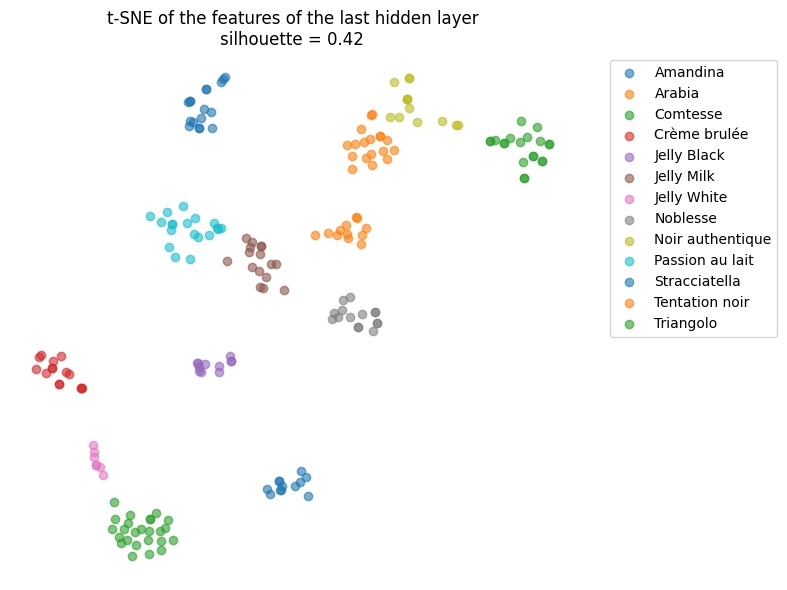

In [14]:
display(Image(filename='image_report/Cluster.jpeg'))

However, we also have some segmentation errors where the model misses certain chocolates.

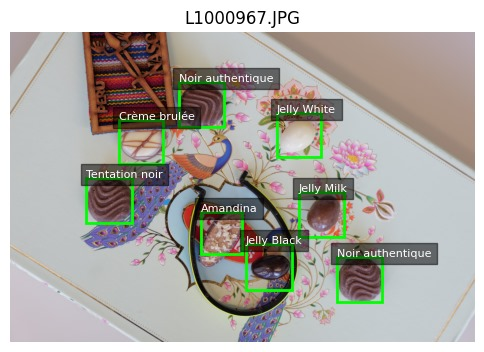

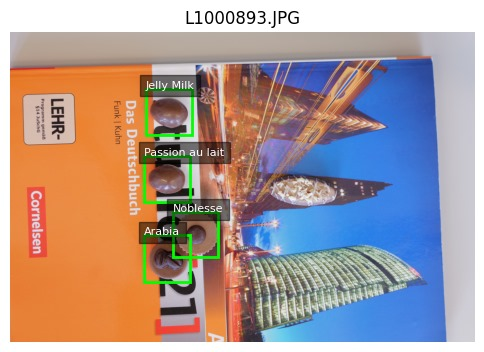

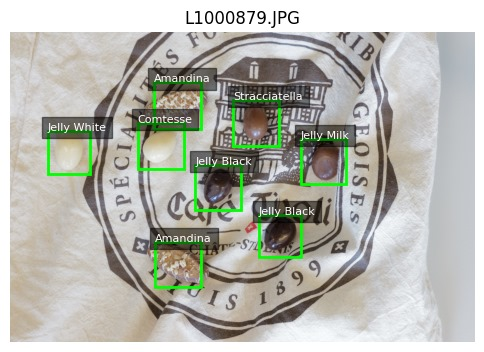

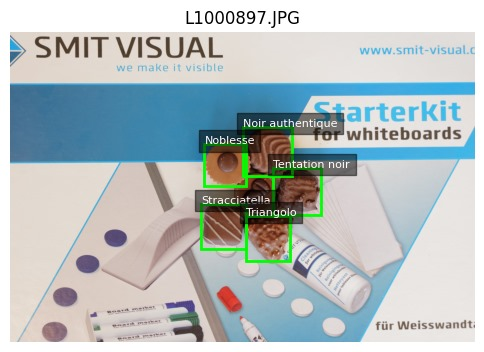

In [15]:

from IPython.display import Image, display


display(Image(filename='image_report/Error_A.jpeg'))
display(Image(filename='image_report/Error_B.jpeg'))
display(Image(filename='image_report/Error_C.jpeg'))
display(Image(filename='image_report/Error_D.jpeg'))